# El cambio climático en la mira

## Autores

* Matias Lisousky
* Alejandro Mora
* Julián Corvalán

## Introducción

El sitio web de la base de datos estadísticos corporativos de la Organización para la
Agricultura y la Alimentación ( FAOSTAT ) difunde estadísticas del cambio de temperatura
superficial promedio por país, con actualizaciones anuales. La difusión actual cubre el
período 1961-2019. Las estadísticas están disponibles para las anomalías de temperatura
media mensual, estacional y anual, es decir, el cambio de temperatura con respecto a una
climatología de referencia, correspondiente al período 1951-1980. También está disponible
la desviación estándar del cambio de temperatura de la metodología de referencia. Los
datos se basan en los datos GISTEMP disponibles públicamente, los datos de cambio de
temperatura de la superficie global distribuidos por el Instituto Goddard de Estudios
Espaciales de la Administración Nacional de Aeronáutica y del Espacio (NASA-GISS).

## Objetivos

El cambio climático es uno de los temas importantes que enfrenta el mundo en esta era tecnológica. La mejor prueba de esta situación es el histórico cambio de temperatura. Se busca, entonces:

* Analizar los valores que se poseen teniendo en cuenta el factor del tiempo (años) y el agrupamiento por continentes.
* Poder analizar y predecir los cambios de temperatura que se esperarían
en los próximos años.

## Preguntas a responder - Alcance y puntos de interés
* ¿En cuanto han cambiado las temperaturas?
* ¿O hay alteraciones particulares en cada continente/zona?
* Si se indentifica alguna anomalía a través de los años, llamando anomalía como un cambio brusco de temperatura, ¿cuando se ha manifestado? ¿Fue global o zonal el alcance?
* ¿El cambio de temperatura es correlativo a través de los años?

El alcance de nuestro estudio es entonces analizar los valores de las lecturas de los cambios de temperatura globales a través de técnicas, métodos y conceptos de la Ciencia de Datos.

## Público de interés

El proyecto evolucionó hacia una línea más informativa y un storytelling orientado a la distribución de información para público con conocimientos básicos de matemática y estadística.

## Tabla de contenidos

* [Data Acquisition](#DataAcquisition)
* [EDA (Exploratory Data Analysis)](#EDA)
  * [Feature Selection](#FeatureSelection)
  * [Instance Selection](#InstanceSelection)
  * [Modelado de datos auxiliares](#DatosAuxiliares)
  * [Análisis estadístico de time_series](#analisis_univariado)
* [Data Wrangling](#DW)
  * [Manejo de datos faltantes](#DatosFaltantes)
  * [Corrección del formato de los datos](#CorreccionFormatoDatos)
  * [Normalizacion de datos](#NormalizacionDatos)
  * [Bins - contenedores](#Bins)
  * [Variables Dummy](#Dummy)
* [Visualizaciones de los datos](#graficos)
  * [Cambio de temperatura global por decada](#grafico_1)
  * [Cambio de temperatura global por continente](#grafico_2)
  * [Verificación de amplitud de lecturas](#grafico_3)
  * [Promedio de lecturas a través de los años](#grafico_4)
  * [Relación entre lecturas y años](#grafico_5)
  * [Verificación de outliers](#grafico_6)
* [¿El cambio de temperatura es correlativo a través de los años?](#ML_tittle)
  * [ML - Regresión lineal](#ML_rl)
  * [OLS - Ordinary Least Squares / Mínimos Cuadrados Ordinarios](#ML_ols)
  * [Entrenamiento con la totalidad de los datos y predicciones futuras](#total_train)
  * [Entrenamiento con particiones de datos](#split_train)
  * [Métricas del modelo](#metrics)
  * [Underfitting & Overfitting](#anyfitting)
  * [Cross-Validation](#cross_val)

## Data Acquisition <a class="anchor" id="DataAcquisition"></a>

En primera instancia vamos a cargar los datos con los que vamos a trabajar y luego hacer una previsualización de los mismos.

In [58]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import numpy as np
import plotly.express as px
from   scipy import stats
import statsmodels.formula.api as sm
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

In [59]:
url = 'https://raw.githubusercontent.com/jcorvalan93/CH_DataScience/main/Environment_Temperature_change.csv'
df = pd.read_csv(url, sep=',', encoding='cp1252')
df.head()

,Area Code,Area,Months Code,Months,Element Code,Element,Unit,Y1961,Y1962,Y1963,...,Y2010,Y2011,Y2012,Y2013,Y2014,Y2015,Y2016,Y2017,Y2018,Y2019
0,2,Afghanistan,7001,January,7271,Temperature change,°C,0.777,0.062,2.744,...,3.601,1.179,-0.583,1.233,1.755,1.943,3.416,1.201,1.996,2.951
1,2,Afghanistan,7001,January,6078,Standard Deviation,°C,1.950,1.950,1.950,...,1.950,1.950,1.950,1.950,1.950,1.950,1.950,1.950,1.950,1.950
2,2,Afghanistan,7002,February,7271,Temperature change,°C,-1.743,2.465,3.919,...,1.212,0.321,-3.201,1.494,-3.187,2.699,2.251,-0.323,2.705,0.086
3,2,Afghanistan,7002,February,6078,Standard Deviation,°C,2.597,2.597,2.597,...,2.597,2.597,2.597,2.597,2.597,2.597,2.597,2.597,2.597,2.597
4,2,Afghanistan,7003,March,7271,Temperature change,°C,0.516,1.336,0.403,...,3.390,0.748,-0.527,2.246,-0.076,-0.497,2.296,0.834,4.418,0.234


Como se puede observar tenemos inicialmente un tabla comprendida por el país o zona de estudio, mes de lectura, tipo de lectura, y las lecturas por año (entre otras columnas).

In [60]:
len(df.Area.unique())

284

Se puede observar que tenemos unas 284 areas en total, las cuales se componen en paises y regiones.

## EDA (Exploratory Data Analysis) <a class="anchor" id="EDA"></a>

A partir de la carga de datos, realizamos un tratamiento previo que nos ayudará luego a generar eficientemente visualizaciones.

In [61]:
temp_df = df.copy()

### Feature Selection <a class="anchor" id="FeatureSelection"></a>

In [62]:
df_object_columns = temp_df.iloc[:, 0:6]
df_object_columns.keys()

Index(['Area Code', 'Area', 'Months Code', 'Months', 'Element Code',
       'Element'],
      dtype='object')

Los datos de estas columnas no serán objeto de estudio ya que reprensentan valores de objetos. Es decir, en estas carecterísticas (features) tenemos información de los países/áreas que comprenden el estudio, mes de la medición de la temperatura y el tipo de medición, más los codigos de cada una.

In [63]:
df_year_columns = temp_df.iloc[:, 7:]
df_year_columns.keys()

Index(['Y1961', 'Y1962', 'Y1963', 'Y1964', 'Y1965', 'Y1966', 'Y1967', 'Y1968',
       'Y1969', 'Y1970', 'Y1971', 'Y1972', 'Y1973', 'Y1974', 'Y1975', 'Y1976',
       'Y1977', 'Y1978', 'Y1979', 'Y1980', 'Y1981', 'Y1982', 'Y1983', 'Y1984',
       'Y1985', 'Y1986', 'Y1987', 'Y1988', 'Y1989', 'Y1990', 'Y1991', 'Y1992',
       'Y1993', 'Y1994', 'Y1995', 'Y1996', 'Y1997', 'Y1998', 'Y1999', 'Y2000',
       'Y2001', 'Y2002', 'Y2003', 'Y2004', 'Y2005', 'Y2006', 'Y2007', 'Y2008',
       'Y2009', 'Y2010', 'Y2011', 'Y2012', 'Y2013', 'Y2014', 'Y2015', 'Y2016',
       'Y2017', 'Y2018', 'Y2019'],
      dtype='object')

Luego tenemos las mediciones de temperaturas de cada año como feature. En el dataset son nuestras **variables objetivos**. Es decir, en todas ellas se centrará nuestro estudio (se intentará predecir los valores de años posteriores) con lo cual no buscamos reducir su dimensionalidad. **<u>Es entonces que no se aplicarán métodos de Feature Selection.</u>**

### Instance Selection <a class="anchor" id="InstanceSelection"></a>

En el dataset, sobre la columna Element se tienen dos valores posibles: Temperature Change y Standard Deviation. Cuando apliquemos un algoritmo de regresión, lo haremos para los valores del primero, con lo cual, necesitamos filtrar las instancias de Element=Standard Deviation.

* Primero, verificamos los valores de Element:

In [64]:
element_values = temp_df['Element'].unique()
print(element_values)

['Temperature change' 'Standard Deviation']


* Segundo, aplicamos **Instance Selection** en nuestro dataset:

In [65]:
#Renombro las columnas para cambiar su estilo de escritura
temp_df = temp_df.rename(columns = {'Area Code':'area_code', 'Area':'area', 'Months Code':'months_code','Months':'months','Element Code':'element_code','Element':'element','Unit':'unit'})
#Elimino los element=Standard Deviation
temp_df.drop(temp_df[temp_df.element_code == 6078].index , inplace = True)

temp_df.head()

,area_code,area,months_code,months,element_code,element,unit,Y1961,Y1962,Y1963,...,Y2010,Y2011,Y2012,Y2013,Y2014,Y2015,Y2016,Y2017,Y2018,Y2019
0,2,Afghanistan,7001,January,7271,Temperature change,°C,0.777,0.062,2.744,...,3.601,1.179,-0.583,1.233,1.755,1.943,3.416,1.201,1.996,2.951
2,2,Afghanistan,7002,February,7271,Temperature change,°C,-1.743,2.465,3.919,...,1.212,0.321,-3.201,1.494,-3.187,2.699,2.251,-0.323,2.705,0.086
4,2,Afghanistan,7003,March,7271,Temperature change,°C,0.516,1.336,0.403,...,3.390,0.748,-0.527,2.246,-0.076,-0.497,2.296,0.834,4.418,0.234
6,2,Afghanistan,7004,April,7271,Temperature change,°C,-1.709,0.117,0.919,...,2.591,1.712,1.417,-0.052,0.585,1.589,0.980,1.252,1.442,0.899
8,2,Afghanistan,7005,May,7271,Temperature change,°C,1.412,-0.092,-0.690,...,1.419,3.643,0.909,1.201,0.959,1.862,3.246,3.280,0.855,0.647


### Modelado de datos auxiliares <a class="anchor" id="DatosAuxiliares"></a>

En esta sección realizamos un procesamiento previo a los datos y crear nuevas estructuras que nos servirán luego para las visualizaciones y análisis.

* Creamos un listado con los meses del año.
* Filtramos columnas que no utilizaremos
* Agrupamos valores por continentes
* Obtenemos el promedio de cambio de temperatura por año

In [66]:
months = ['January','February','March','April','May','June','July','August','September','October','November','December']
temp_months = temp_df[temp_df['months'].isin(months)]

temp_year = temp_df[(temp_df["months"]=="Meteorological year")]
temp_year = temp_year.drop(["area_code","months_code","months","element","element_code","unit"],axis=1)
temp_year = temp_year.T
temp_year.columns = temp_year.loc['area']
temp_year.drop('area', inplace = True)

Continents = temp_year[["Africa","Asia","Europe","Northern America","South America","Oceania","Antarctica"]] 
Continents = Continents.rename(columns={"Northern America":"N_America","South America":"S_America"})
Continents.reset_index(level=0, inplace=True)
Continents = Continents.rename(columns={"index":"Year"})
idx = Continents.columns[1:].tolist()

In [67]:
def preprocess_inputs(_df):
    _df = _df.groupby('area')\
            .mean()\
            .loc[:, 'Y1961':]
    
    # promedio/media de temperatura global
    _df = pd.DataFrame(_df.mean()).reset_index(drop=False)
    
    #renombro columnas y cambio el tipo de dato de la columna año
    #esto ultimo se hace para que me pueda tomar como una serie de tiempo y no como elementos por separado
    _df.columns=['year', 'temperature_change']
    _df['year'] = _df['year'].apply(lambda x: x[1:]).astype(int)
    
    return _df

In [68]:
time_series = preprocess_inputs(temp_df)
time_series.head()

,year,temperature_change
0,1961,0.143032
1,1962,-0.028398
2,1963,-0.026297
3,1964,-0.122865
4,1965,-0.224154


## Análisis estadístico de time_series <a class="anchor" id="analisis_univariado"></a>

Dado que en las próximas secciones utilizaremos este set de datos para realizar visualizaciones y analisis de ciencia de datos, necesitamos previamente estudiar la calidad de estas lecturas, teniendo en cuenta su distribución y las medidas de tendencia central.

Entonces, en esta sección, haremos un breve análisis estadístico univariado, con el objetivo de analizar las lecturas de las mediciones por año con una mirada estadística de tipo descriptivo. En resultado, nos agrega valor en nuestra exploración de los datos.

In [69]:
import scipy 
scipy.stats.describe(time_series['temperature_change'])

DescribeResult(nobs=59, minmax=(-0.22415409663865546, 1.4648986274368048), mean=0.4700899661775744, variance=0.22498114569237165, skewness=0.38775568372912556, kurtosis=-0.9810871140299633)

Resultados obtenidos:



*   **nobs**

Representa el número de observaciones. El periodo de tiempo de la mediciones es de 59 años (1961-2019).

*   **minmax**

Valor mínimo y máximo de los promedios anuales de las mediciones.

*   **mean**

Promedio o media de los promedios anuales de las mediciones.

*   **variance**

La varianza es una medida de dispersión que representa la variabilidad de una serie de datos respecto a su media. En este caso es la varianza de los promedios anuales de las mediciones.

*   **skewness**

Refiere a la medida de asimetría de los datos.

La asimetría se refiere a la distorsión de simetría. 
Una distribución, o conjunto de datos, es simétrico si se ve igual a la izquierda y a la derecha del punto central.
Son medidas de tercer momento y nos permiten entender si es que la distribución de valores numéricos es normal o no.

>Dado que hemos obtenido una asimetría de **0.38** podemos decir **los promedios anuales de las mediciones se consideran muy similares a una distribución normal**.

*   **kurtosis**

Es una medida del grado de cuántos valores atípicos hay. Para una distribución normal, el valor del estadístico de curtosis es 0. Una curtosis positiva indica que los datos muestran más valores atípico extremos que una distribución normal. La curtosis negativa indica que los datos presentan valores atípicos menos extremados que una distribución normal.

>Dado que hemos obtenido un valor de curtosis de **-0.98**, podemos afirmar que **los promedios anuales de las mediciones presentan una curtosis negativa**, lo que significa que tiene un pico más plano y colas más delgadas en comparación con una distribución normal.


In [70]:
from IPython.display import Image
from IPython.core.display import HTML

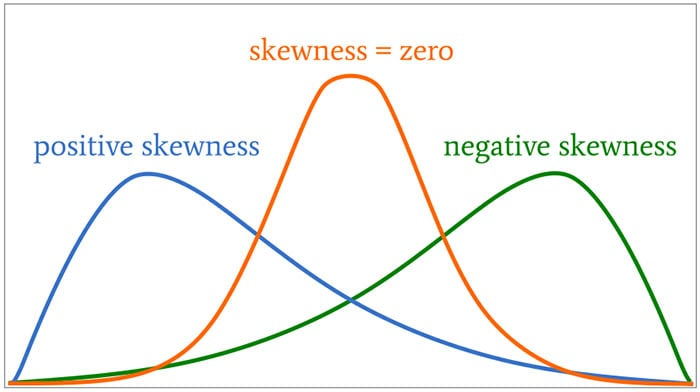

In [71]:
url= "https://www.allaboutcircuits.com/uploads/articles/understanding-the-normal-distribution-parametric-tests-skewness-and-kurtosis-rk-aac-image2.jpg"
Image(url, width=450, height=300)

In [72]:
Image(url= "https://community.sw.siemens.com/servlet/rtaImage?eid=ka64O000000kDup&feoid=00N4O000006Yxpf&refid=0EM4O00000113Pw")

### Medidas de dispersión


In [73]:
print("Coef. Variación: ", scipy.stats.variation(time_series['temperature_change']))

Coef. Variación:  1.0004147158822905


In [74]:
print("IQR: ", scipy.stats.iqr(time_series['temperature_change']))

IQR:  0.7894107767772274


In [75]:
print("Error estándar: ", scipy.stats.sem(time_series['temperature_change']))

Error estándar:  0.06175143526670312


Resultados obtenidos:

* **Coeficiente de Variación**

Refiere a la relación entre el tamaño de la media y la variabilidad de la variable.

>Al tener como resultado un valor de este coeficiente mayor a uno, podemos observar una alta variabilidad de las mediciones de los promedios anuales de las lecturas.

* **IQR - rango intercuartílico**

El rango intercuartílico es una medida de variabilidad adecuada cuando la medida de posición central empleada ha sido la mediana. Se define como la diferencia entre el tercer cuartil (Q3) y el primer cuartil (Q1), es decir: RQ = Q3 - Q1. A la mitad del rango intercuartil se le conoce como desviación cuartil (DQ), es afectada muy poco por cuentas extremas. Esto lo hace una buena medida de dispersión para distribuciones sesgadas: DQ = RQ/2= (Q3 - Q1)/2

>Teniendo en cuenta que nuestros valores mínimos y máximos son [-0.22, 1.46] respectivamente, podemos observar una variabilidad alta entre cuartiles, teniendo en cuenta que la media de las mediciones es de 0.47.

* **Error estandar**

Representa a la desviación estandar. Es el valor que cuantifica cuánto se apartan los valores de la media de la población. Es decir, el error estándar de la media cuantifica las oscilaciones de la media muestral  (media obtenida en base a los datos medidos en la muestra utilizada) alrededor de la media poblacional (verdadero valor de la media). Es una medida del error que se comete al tomar la media calculada en una muestra como estimación de la media de la población total.

>Según el resultado obtenido, observamos un error medio bajo en las mediciones del promedios anuales.

### Medidas de asimetría y kurtosis

Estas medidas informan sobre dos aspectos importantes de la forma de la distribución: su grado de asimetría y su grado de homogeneidad. Al ser medidas de forma, no dependen de las unidades de medida de los datos

In [76]:
print("Skewness: ", scipy.stats.skew(time_series['temperature_change']))

Skewness:  0.38775568372912556


In [77]:
print("Kurtosis: ", scipy.stats.kurtosis(time_series['temperature_change']))

Kurtosis:  -0.9810871140299633


Resultados obtenidos:

* **Skewness**

Presenta una asimetría positiva.

* **Kurtosis**

Presenta una kurtosis negativa.

### Verificación de los datos y la curva normal

Sabiendo los valores de skewness y kurtosis, queremos evaluar si nuestras lecturas de los promedios anuales coinciden con una curva normal.

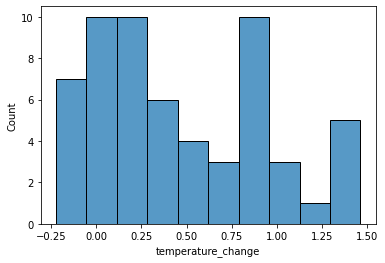

In [78]:
sns.histplot(time_series['temperature_change'], bins=10, kde=False)

>En este histograma podemos observar que confirma la asimetría positiva observada anteriormente.

In [79]:
stats.shapiro(time_series['temperature_change'])

ShapiroResult(statistic=0.9409127831459045, pvalue=0.006501821335405111)

La prueba Shapiro-Wilk formula como hipótesis nula que los datos siguen una distribución normal. El valor resultante luego se analiza para aceptar o no esta hipótesis.

Si pvalue > 0.05 --> indica no rechazar la hipotesis nula.

>Es entonces que podemos indicar gracias a la prueba shapiro, que nuestra variable no cumple estadisticamente con una curva normal.

((array([-2.26751093, -1.90574552, -1.6934328 , -1.53794117, -1.41266963,
         -1.30632291, -1.21299259, -1.12917851, -1.05262603, -0.98179205,
         -0.91557053, -0.85313927, -0.79386855, -0.73726396, -0.68292896,
         -0.63053958, -0.57982669, -0.53056337, -0.48255566, -0.43563558,
         -0.38965586, -0.34448587, -0.30000832, -0.25611675, -0.21271332,
         -0.16970714, -0.1270127 , -0.08454864, -0.04223656,  0.        ,
          0.04223656,  0.08454864,  0.1270127 ,  0.16970714,  0.21271332,
          0.25611675,  0.30000832,  0.34448587,  0.38965586,  0.43563558,
          0.48255566,  0.53056337,  0.57982669,  0.63053958,  0.68292896,
          0.73726396,  0.79386855,  0.85313927,  0.91557053,  0.98179205,
          1.05262603,  1.12917851,  1.21299259,  1.30632291,  1.41266963,
          1.53794117,  1.6934328 ,  1.90574552,  2.26751093]),
  array([-0.2241541 , -0.2109072 , -0.17764935, -0.16784126, -0.13197513,
         -0.1288408 , -0.12286501, -0.04993604, -

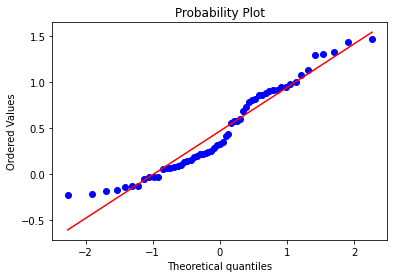

In [80]:
import pandas_profiling
stats.probplot(time_series.temperature_change, dist = 'norm', plot=plt)

Un gráfico Cuantil-Cuantil permite observar cuan cerca está la distribución de un conjunto de datos a alguna distribución ideal.

>Entonces, el grafico Q-Q nos indica que la variable se acerca visualmente a una curva normal. Pero como ya vimos en el analisis anterior, con el test de shapiro, esta variable estadísticamente no se acerca a una curva normal.

## Data Wrangling <a class="anchor" id="DW"></a>

Previo a visualizar y analizar nuestros datos, debemos llevarlos a un proceso de limpieza y corrección con el objetivo de disminuir el riesgo a errores y fallos en su manipulación, así como también poder facilitar el acceso y el análisis de ellos.

### Manejo de datos faltantes <a class="anchor" id="DatosFaltantes"></a>

En primera instancia debemos verificar la cantidad de valores nulos que tenemos en cada una de las columnas del dataset.

In [81]:
df.isnull().sum()

Area Code          0
Area               0
Months Code        0
Months             0
Element Code       0
                ... 
Y2015           1295
Y2016           1308
Y2017           1290
Y2018           1307
Y2019           1291
Length: 66, dtype: int64

* Como se puede observar, las columnas que contienen valores nulos son las que representan los años.

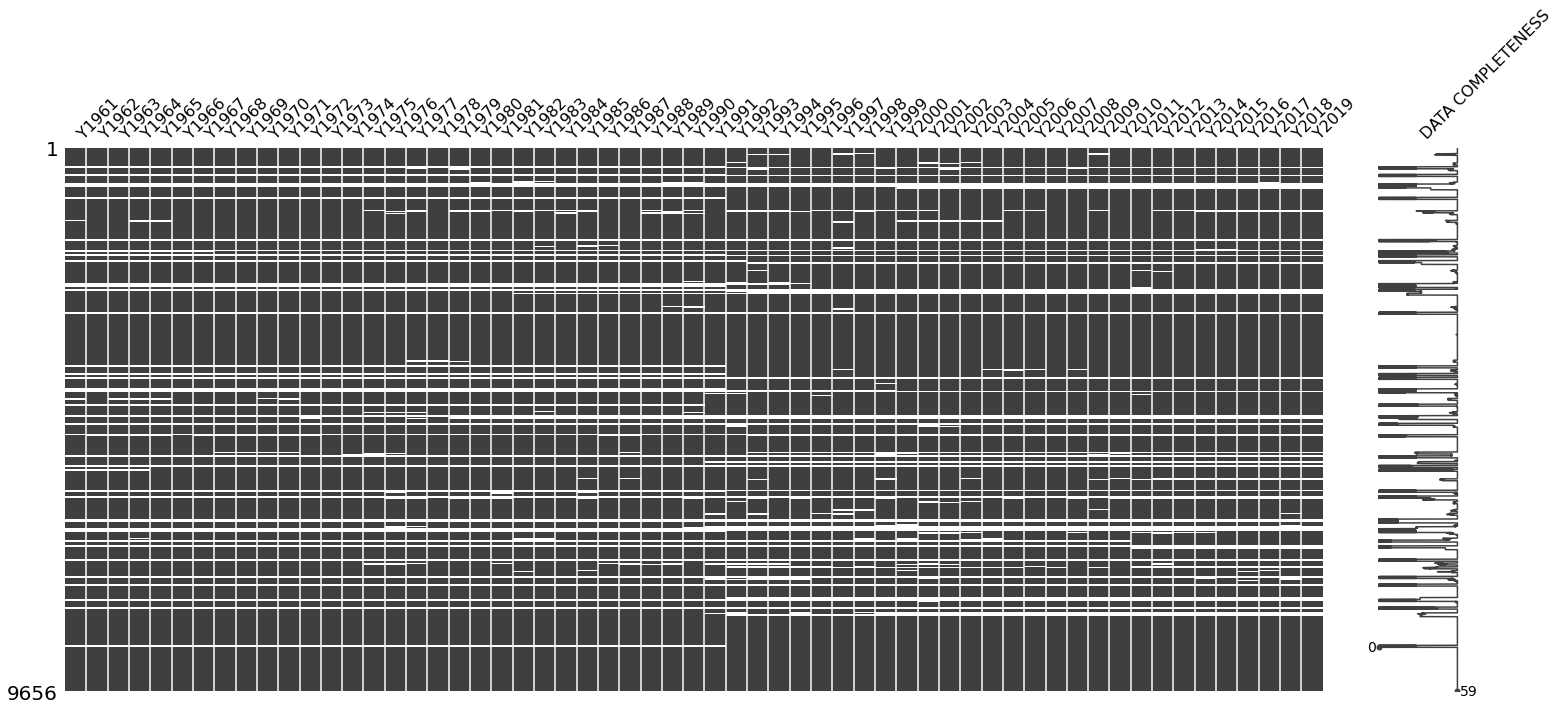

In [82]:
soloYears = df.iloc[:, 7:]
msno.matrix(soloYears, labels=True)

* Usamos la libreria Missigno para explorar y entender de qué forma están compuestos los nulos. Como las columnas son los cambios de temperatura a través de los años, se pasaran a rellenar estos vacios con 0 (antes que null es preferible tener como que no hubo cambios de temperatura ese año)

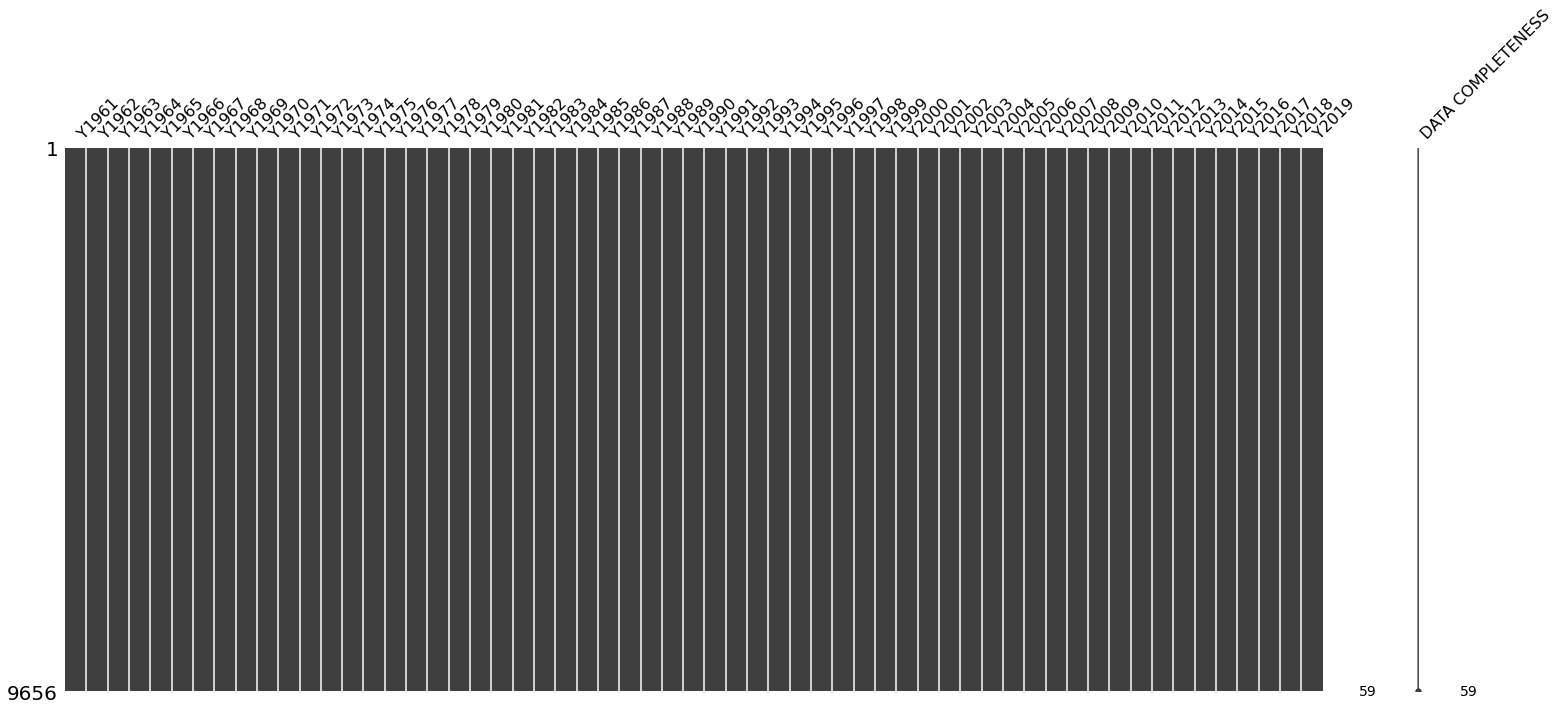

In [83]:
df.replace(np.nan, 0, inplace = True)
soloYears = df.iloc[:, 7:]
msno.matrix(soloYears, labels=True)

### Corrección del formato de los datos <a class="anchor" id="CorreccionFormatoDatos"></a>

En esta sección buscamos verificar y realizar correcciones en los formatos de las columnas del dataset. Ésto es básicamente para intentar prevenir cualquier error de tipo de datos que podamos tener a futuro.

Verificamos primero las columnas de las lecturas por año:

In [84]:
soloYears.dtypes

Y1961    float64
Y1962    float64
Y1963    float64
Y1964    float64
Y1965    float64
Y1966    float64
Y1967    float64
Y1968    float64
Y1969    float64
Y1970    float64
Y1971    float64
Y1972    float64
Y1973    float64
Y1974    float64
Y1975    float64
Y1976    float64
Y1977    float64
Y1978    float64
Y1979    float64
Y1980    float64
Y1981    float64
Y1982    float64
Y1983    float64
Y1984    float64
Y1985    float64
Y1986    float64
Y1987    float64
Y1988    float64
Y1989    float64
Y1990    float64
Y1991    float64
Y1992    float64
Y1993    float64
Y1994    float64
Y1995    float64
Y1996    float64
Y1997    float64
Y1998    float64
Y1999    float64
Y2000    float64
Y2001    float64
Y2002    float64
Y2003    float64
Y2004    float64
Y2005    float64
Y2006    float64
Y2007    float64
Y2008    float64
Y2009    float64
Y2010    float64
Y2011    float64
Y2012    float64
Y2013    float64
Y2014    float64
Y2015    float64
Y2016    float64
Y2017    float64
Y2018    float64
Y2019    float

* Se puede observar que todas las columnas de años se encuentran con el formato correcto.

Luego el resto de las columnas:

In [85]:
sinYears = df.iloc[:, 0:7]
sinYears.dtypes

Area Code        int64
Area            object
Months Code      int64
Months          object
Element Code     int64
Element         object
Unit            object
dtype: object

Para las columnas cuyo tipo es object, las cambiamos a tipo string (conjunto de caracteres)

In [86]:
df[['Area']] = df[['Area']].astype('str')
df[['Months']] = df[['Months']].astype('str')
df[['Element']] = df[['Element']].astype('str')
df[['Unit']] = df[['Unit']].astype('str')
df.dtypes

Area Code         int64
Area             object
Months Code       int64
Months           object
Element Code      int64
                 ...   
Y2015           float64
Y2016           float64
Y2017           float64
Y2018           float64
Y2019           float64
Length: 66, dtype: object

* Aparentemente no es necesario/no lo hace convertir de tipo object a string. El resto de las columnas tiene bien el tipo

### Normalizacion de datos <a class="anchor" id="NormalizacionDatos"></a>

* Los datos ya se encuentran nornalizados.

### Bins - contenedores <a class="anchor" id="Bins"></a>

* No fue posible de aplicar, la varianza de los datos ya es pequeña.

### Variables Dummy <a class="anchor" id="Dummy"></a>

* Los datos solo indican cambios de temperatura, no existen otras categorias para reemplazar.

## Visualizaciones de los datos <a class="anchor" id="graficos"></a>

### Cambio de temperatura global por decada <a class="anchor" id="grafico_1"></a>
En este primer grafico analizamos las lecturas de los cambios de temperatura por decada, a través de los meses.

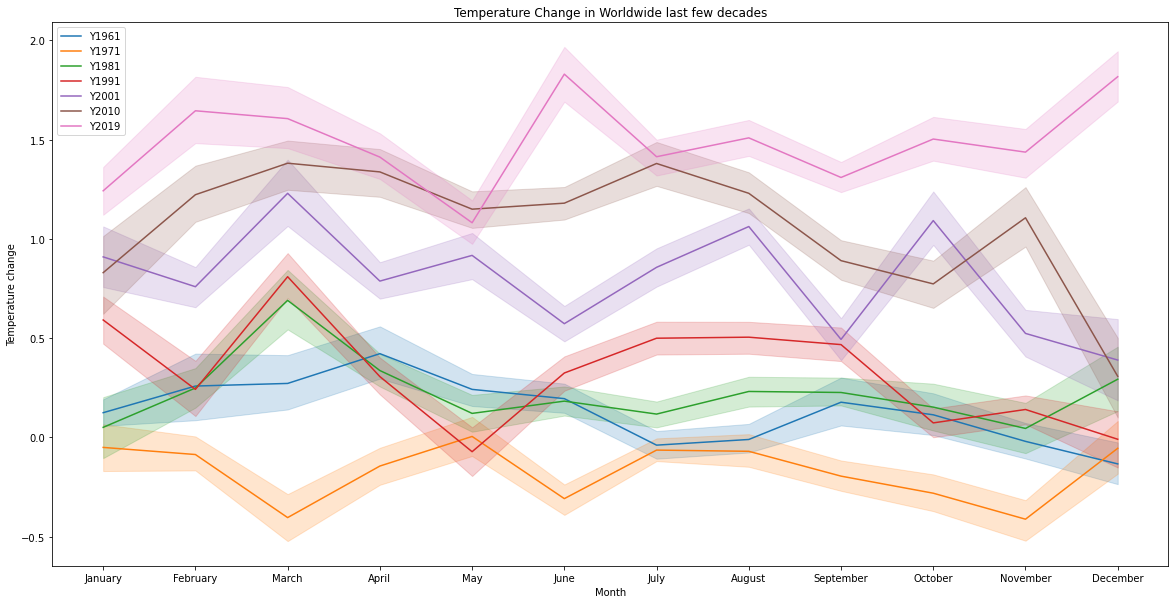

In [87]:
plt.figure(figsize=(20,10))
sns.lineplot(x=temp_months.months.loc[temp_months.element=='Temperature change'],y=temp_months.Y1961.loc[temp_months.element=='Temperature change'], label='Y1961')
sns.lineplot(x=temp_months.months.loc[temp_months.element=='Temperature change'],y=temp_months.Y1971.loc[temp_months.element=='Temperature change'], label='Y1971')
sns.lineplot(x=temp_months.months.loc[temp_months.element=='Temperature change'],y=temp_months.Y1981.loc[temp_months.element=='Temperature change'], label='Y1981')
sns.lineplot(x=temp_months.months.loc[temp_months.element=='Temperature change'],y=temp_months.Y1991.loc[temp_months.element=='Temperature change'], label='Y1991')
sns.lineplot(x=temp_months.months.loc[temp_months.element=='Temperature change'],y=temp_months.Y2001.loc[temp_months.element=='Temperature change'], label='Y2001')
sns.lineplot(x=temp_months.months.loc[temp_months.element=='Temperature change'],y=temp_months.Y2010.loc[temp_months.element=='Temperature change'], label='Y2010')
sns.lineplot(x=temp_months.months.loc[temp_months.element=='Temperature change'],y=temp_months.Y2019.loc[temp_months.element=='Temperature change'], label='Y2019')
plt.xlabel('Month')
plt.ylabel('Temperature change')
plt.title('Temperature Change in Worldwide last few decades')
plt.show()

Se observa que el cambio de temperaturas fue en aumento en las últimas 4 décadas.

Además, durante el mes de diciembre en las últimas dos décadas, se observa la mayor diferencia de lecturas en un mismo periodo.

### Cambio de temperatura global por continente <a class="anchor" id="grafico_2"></a>

En este segundo gráfico analizamos las lecturas de los cambios de temperatura por continente, a través de los años.

In [88]:
fig = px.line(Continents, x=Continents.Year, y=Continents.columns[1:],
              title='Temperature in °C over countries', width=1500)

fig.update_layout(
    updatemenus=[
        dict(
            active=0,
            buttons=list([dict(label="None",
                     method="update",
                     args=[{"visible": [True for _ in range(186)]},
                           {"title": "Temperature in °C over continents",
                            "annotations": []}])]) + list([
                dict(label=f"{j}",
                     method="update",
                     args=[{"visible": [True if i==idx else False for i in range(186)]},
                           {"title": f"{j}",
                            "annotations": []}]) for idx,j in enumerate(Continents.columns[1:])])
            )])

fig.show()

Se observa una pendiente positiva sobre el grafico de lineas de cambios de temperaturas, confirmando el gráfico anterior, y por otro lado, verificando el aumento de temperaturas, principalmente en las últimas décadas, teniendo la minoría de mediciones por debajo del cero.

### Verificación de amplitud de lecturas <a class="anchor" id="grafico_3"></a>

En este tercer gráfico representamos las densidades de los valores de las lecturas de los cambios de temperatura por continente, buscando observar los rangos númericos de estos valores.

Con ello, cuanto más extendido verticalmente se observa el objeto en el gráfico, nos puede comunicar la amplitud de las lecturas.

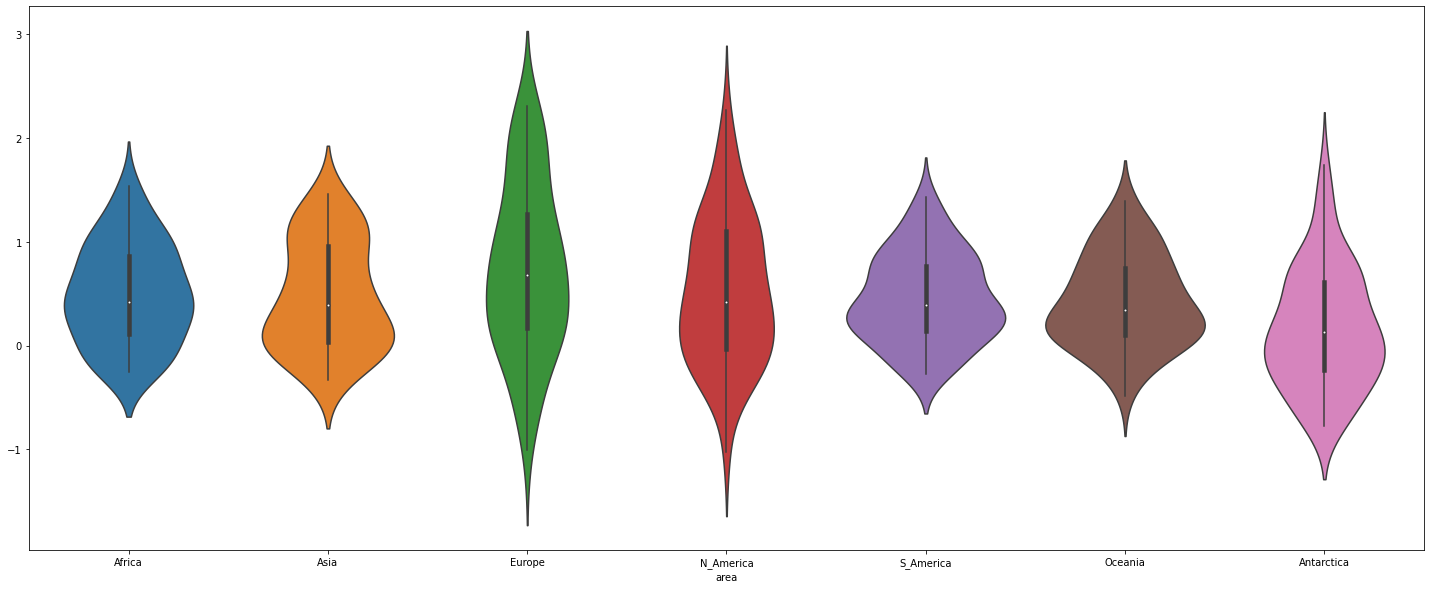

In [89]:
fig, ax = plt.subplots(figsize =(25, 10)) 
sns.violinplot(ax = ax, data = Continents.iloc[:,0:])

Como podemos observar, cambios extremos se han dado en Europa y America del Norte.

### Promedio de lecturas a través de los años <a class="anchor" id="grafico_4"></a>

En este cuarto gráfico representamos los promedio de los valores de las lecturas de los cambios de temperatura (globales) en una serie de tiempo.

Con ello, queremos visualizar y entender cómo es la tendencia de las lecturas.

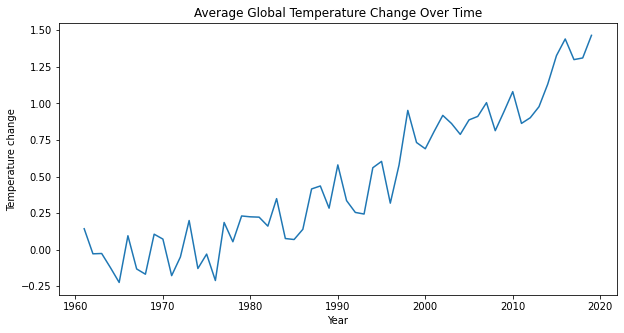

In [90]:
plt.figure(figsize=(10,5))
sns.lineplot(x=time_series.year,y=time_series.temperature_change)
plt.xlabel('Year')
plt.ylabel('Temperature change')
plt.title('Average Global Temperature Change Over Time')
plt.show()

Tal y como hemos visto en el segundo gráfico, se observa un aumento de las temperaturas en el transcurso del tiempo, siendo las últimas tres décadas las más significativas.

### Relación entre lecturas y años <a class="anchor" id="grafico_5"></a>

En este quinto gráfico representamos la relación de los promedios de los valores de las lecturas de los cambios de temperatura (globales) y una serie de tiempo.

Con ello, queremos visualizar y verificar la distribución de las lecturas a través del tiempo.

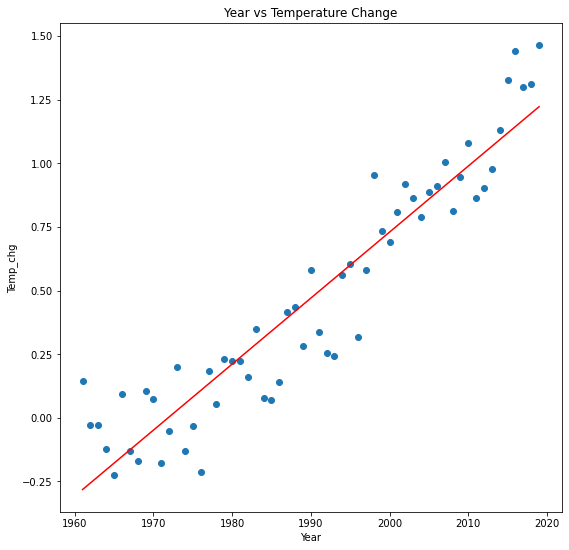

In [91]:
fig, ax = plt.subplots(figsize = (9, 9))
ax.scatter(time_series.year, time_series.temperature_change)
ax.set_title('Year vs Temperature Change')
ax.set_xlabel('Year')
ax.set_ylabel('Temp_chg')
m, b = np.polyfit(time_series.year, time_series.temperature_change, deg=1)
#ecuacion de la recta -> y=mx+b
tendency_line = m*time_series.year + b
plt.plot(time_series.year, tendency_line, color='red')


En este gráfico podemos reforzar lo observado en los gráficos 1, 2 y 4 en el cual nos muestra una pendiente ascendente de los valores de las lecturas con respecto a los años. 

Además no se observan puntos muy alejados de la linea de tendencia (recta en rojo) que se ha marcado. Esto nos puede indicar que muy posiblemente no hayan valores anormales, o que por lo menos no han se tienen lecturas extremas con respecto a la media.

### Verificación de outliers <a class="anchor" id="grafico_6"></a>

En este sexto gráfico intentamos identificar los valores atípicos. Es decir, poder observar las lecturas que sean numericamente distantes del resto de los datos. Estos valores pueden afectar potencialmente a los próximos análisis que haremos.

Text(0.5, 1.0, 'Temperature change distribution')

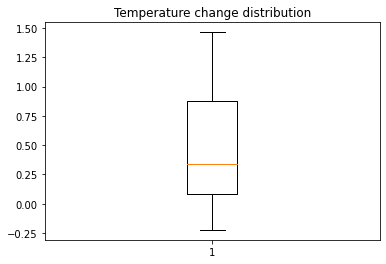

In [92]:
fig2, ax2 = plt.subplots()
ax2.boxplot(time_series.temperature_change)
ax2.set_title("Temperature change distribution")

Utilizando el dataframe de time_series no se observan outliers sobre los valores de temperature_change.

Además refuerza lo observado en el gráfico anterior.

## ¿El cambio de temperatura es correlativo a través de los años? <a class="anchor" id="ML_tittle"></a>

### ML - Regresión lineal <a class="anchor" id="ML_rl"></a>

Entonces, en las visualizaciones podemos observar: 
+ La dispersión de datos (scatterplot) se observa una leve correlación entre el año y el cambio de temperatura.
+ La tendencia (la pendiente) es positiva, es decir que los cambios de temperaturas tienden a aumentar a través de los años.

Dado que con observar gráficos no es suficiente, ya que posee un factor subjetivo, procedemos a realizar un analisis estadístico utilizando regresión lineal en un modelo de Machine Learning, diseñado a partir de dos hipotesis que se desprenden de aquella observación:

**Hipotesis nula** : `Ho = el cambio de temperatura es correlativo con los años.`

**Hipotesis alternativa**: `Hi = el cambio de temperatura y los años son variables independientes.`

In [93]:
time_series.temperature_change.describe()

count    59.000000
mean      0.470090
std       0.474322
min      -0.224154
25%       0.085562
50%       0.335127
75%       0.874973
max       1.464899
Name: temperature_change, dtype: float64

### OLS - Ordinary Least Squares / Mínimos Cuadrados Ordinarios <a class="anchor" id="ML_ols"></a>

Aplicaremos este algoritmo de regresión, definiendo nuestro modelo a partir de las hipotesis generadas:

_"La temperatura es correlacional al año"_

Entonces en este modelo suponemos que:

`temperature_change: variable dependiente`

`year: variable independiente`

In [94]:
model1 = 'temperature_change~year'

lm1 = sm.ols(formula = model1, data = time_series).fit()

print(lm1.summary())

                            OLS Regression Results                            
Dep. Variable:     temperature_change   R-squared:                       0.881
Model:                            OLS   Adj. R-squared:                  0.879
Method:                 Least Squares   F-statistic:                     423.1
Date:                Tue, 22 Nov 2022   Prob (F-statistic):           4.72e-28
Time:                        22:02:11   Log-Likelihood:                 23.654
No. Observations:                  59   AIC:                            -43.31
Df Residuals:                      57   BIC:                            -39.15
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -51.1203      2.508    -20.381      0.0

**Observaciones OLS**

+ coef != 0 y p_value < 0.05  => me indica rechazar la hipotesis nula
+ prob JB > 0.05 => me indica no rechazar la hipotesis nula
+ DW en [0;4] => me indica que las variables son independientes => rechazo la hipotesis nula

### Entrenamiento con la totalidad de los datos y predicciones futuras <a class="anchor" id="total_train"></a>

A partir de nuestro modelo creado, procedemos a realizar en primera instancia un entrenamiento de nuestro dataset, con la particularidad que utilizaremos la totalidad de nuestros datos y luego, como datos de prueba, se utilizan datos (años) futuros.

Con ello buscamos verificar la calidad de nuestros datos y poder realizar predicciones con valores que no poseemos aún.

In [95]:
# Asignamos nuestra variable de entrada X para entrenamiento y las etiquetas Y.
dataX = time_series[["year"]]
df_x = np.array(dataX)
df_y = time_series['temperature_change'].values
 
# Creamos el objeto de Regresión Linear
regr = linear_model.LinearRegression()
 
# Entrenamos nuestro modelo
regr.fit(df_x, df_y)
 
# Hacemos las predicciones que en definitiva una línea (en este caso, al ser 2D)
pred = regr.predict(df_x)
 
# Veamos los coeficienetes obtenidos, En nuestro caso, serán la Tangente
print('Coefficients: \n', regr.coef_)
# Este es el valor donde corta el eje Y (en X=0)
print('Independent term: \n', regr.intercept_)
# Error Cuadrado Medio
print("Mean squared error: %.2f" % mean_squared_error(df_y, pred))
# Puntaje de Varianza. El mejor puntaje es un 1.0
print('Variance score: %.2f' % r2_score(df_y, pred))

Coefficients: 
 [0.02592483]
Independent term: 
 -51.12031976321558
Mean squared error: 0.03
Variance score: 0.88


**Observaciones de la regresion lineal**

+ De la ecuación de la recta y = mx + b nuestra pendiente “m” es el coeficiente 0.025 y el término independiente “b” es -51.12
+ Tenemos un Error Cuadrático relativamente bajo 0.03
+ El puntaje de Varianza es 0.88 con lo cual es cercano a 1.0

**Predicción en regresión lineal**

Vamos a intentar probar nuestro algoritmo, suponiendo que quisiéramos predecir el valor de cambio de temperatura para la decada 2019-2029.

In [96]:
from operator import itemgetter

future_predictions = []
years = range(2020, 2030)

for y in years:
    prediction = regr.predict([[y]])
    future_predictions.append(itemgetter(0)(prediction))
    print(f"Year: {y} | temperature_change: {itemgetter(0)(prediction)}")

Year: 2020 | temperature_change: 1.2478348364699343
Year: 2021 | temperature_change: 1.2737596654796803
Year: 2022 | temperature_change: 1.2996844944894264
Year: 2023 | temperature_change: 1.3256093234991724
Year: 2024 | temperature_change: 1.3515341525089113
Year: 2025 | temperature_change: 1.3774589815186573
Year: 2026 | temperature_change: 1.4033838105284033
Year: 2027 | temperature_change: 1.4293086395381494
Year: 2028 | temperature_change: 1.4552334685478954
Year: 2029 | temperature_change: 1.4811582975576414


In [97]:
last_decade = time_series.tail(10).copy()
last_decade

,year,temperature_change
49,2010,1.080097
50,2011,0.863045
51,2012,0.901637
52,2013,0.977131
53,2014,1.131417
54,2015,1.326462
55,2016,1.440185
56,2017,1.299112
57,2018,1.310459
58,2019,1.464899


In [98]:
last_decade.temperature_change.describe()

count    10.000000
mean      1.179444
std       0.219333
min       0.863045
25%       1.002873
50%       1.215265
75%       1.322462
max       1.464899
Name: temperature_change, dtype: float64

In [99]:
mean_pred = np.mean(future_predictions, axis=None)
min_pred = np.min(future_predictions)
max_pred = np.max(future_predictions)

print(f"Mean: {mean_pred} | min: {min_pred} | max: {max_pred}")

Mean: 1.3644965670137872 | min: 1.2478348364699343 | max: 1.4811582975576414


**Analizando las predicciones**

Entre el 2010 y el 2019, la media de los cambios de temperatura fue de 1.179444, con minimo de 0.863045 y un maximo de 1.464899. Mientras que la predicción arrojó resultados como 1.3644965, 1.2478348, 1.4811582 respectivamente.

A simple vista, los valores no parecen "irreales", o por lo menos mantienen la coherencia que expusimos en el EDA (tendencia de aumento de temperatura).

### Entrenamiento con particiones de datos <a class="anchor" id="split_train"></a>

En el modelo anterior, los datos de prueba fueron valores que no estaban en nuestro rango (utilizamos años futuros). Luego hicimos un entrenamiento sobre todos los datos y una predicción sobre estos datos futuros.

Entonces, esta vez, vamos a crear nuevamente un modelo distinto, realizando una división del dataframe entre los datos de entrenamiento y de prueba (20% del total).

In [100]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

# Separo las muestras para la validación
X_train,X_test,y_train,y_test = train_test_split(df_x,df_y,test_size=0.2,random_state=2)


# crear el modelo, se ajusta y se realiza una predicción a partir de las muestras 
lr = LinearRegression()
lr.fit(X_train,y_train)
y_pred = lr.predict(X_test)

print(y_pred)

[ 0.91460123  0.46345921  0.6226858   1.17997889  0.30423261  0.96767676
  0.43692144 -0.30613602  0.48999697 -0.27959825  1.12690336  1.1003656 ]


### Métricas del modelo <a class="anchor" id="metrics"></a>


##### > <u>Error Cuadrático Medio (MSE)</u>

MSE mide el error cuadrado promedio de nuestras predicciones. Para cada punto, calcula la diferencia cuadrada entre las predicciones y el objetivo y luego promedia esos valores.

Cuanto mayor sea este valor, peor es el modelo. Nunca es negativo, ya que estamos cuadrando los errores de predicción individuales antes de sumarlos, pero sería cero para un modelo perfecto.

In [101]:
from sklearn.metrics import mean_squared_error
print("MSE",mean_squared_error(y_test,y_pred))

MSE 0.04453966298145321


##### > <u>Raiz del Error Cuadrático Medio (RMSE)</u>

RMSE es solo la raíz cuadrada de MSE. La raíz cuadrada se introduce para hacer que la escala de los errores sea igual a la escala de los objetivos.

In [102]:
print("RMSE",np.sqrt(mean_squared_error(y_test,y_pred)))

RMSE 0.21104422044077212


In [103]:
print("RMSE (log)",np.log(np.sqrt(mean_squared_error(y_test,y_pred))))

RMSE (log) -1.555687591915275


##### > <u>Error Absoluto Medio (MAE)</u>

En MAE, el error se calcula como un promedio de diferencias absolutas entre los valores objetivo y las predicciones. El MAE es una puntuación lineal, lo que significa que todas las diferencias individuales se ponderan por igual en el promedio. Por ejemplo, la diferencia entre 10 y 0 será el doble de la diferencia entre 5 y 0.

In [104]:
from sklearn.metrics import mean_absolute_error
print("MAE",mean_absolute_error(y_test,y_pred))

MAE 0.17677074341098067


##### > <u>R-Cuadrado (R2)</u>

R-cuadrado indica la bondad o la aptitud del modelo, a menudo se utiliza con fines descriptivos y muestra que también las variables independientes seleccionadas explican la variabilidad en sus variables dependiente.

R-cuadrado tiene la propiedad útil de que su escala es intuitiva, va de 0 a 1, con 0 indicando que el modelo propuesto no mejora la predicción sobre el modelo medio y 1 indica una predicción perfecta.

In [105]:
from sklearn.metrics import r2_score
r2 = r2_score(y_test,y_pred)
print("R2",r2)

R2 0.8024775718896223


##### Analisis de las métricas

Para este nuevo modelo generado, nos encontramos que:
+ Teniendo en cuenta el valor de **MSE** nos podría indicar que los valores de la pendiente y del interceptor es cercano al real, el cual minimiza el error cuadrático. Es decir, la ecuación de la recta formada por el modelo es similar a la ecuación real.
+ Teniendo en cuenta el valor de **MAE**, el cual indica el promedio de la diferencia absoluta entre la predicción del modelo y el valor objetivo. Nos da idea de la sensibilidad de las medidas por lo poco dispersas que resultaron. El error absoluto nos indica el grado de aproximación y da un indicio de la calidad de la medida.
+ Finalmente teniendo en cuenta el valor de **R2**, el cual se acerca a 1, se puede decir que se tiene, en el modelo, una buena precisión sobre las predicciones realizadas.

(!) Luego, en la siguiente sección se podrá ver visualmente estas "distancias" (diferencias) entre la predicción y los valores reales.

### Underfitting & Overfitting <a class="anchor" id="anyfitting"></a>

Las principales causas al obtener malos resultados en Machine Learning son el Overfitting o el Underfitting de los datos. Cuando entrenamos nuestro modelo intentamos “hacer encajar” -fit en inglés- los datos de entrada entre ellos y con la salida. Tal vez se pueda traducir overfitting como “sobreajuste” y underfitting como “subajuste” y hacen referencia al fallo de nuestro modelo al generalizar -encajar- el conocimiento que pretendemos que adquieran.

Habiendo entendido ambos conceptos, procedemos a analizar visualmente el comportamiento del modelo anteriormente generado:

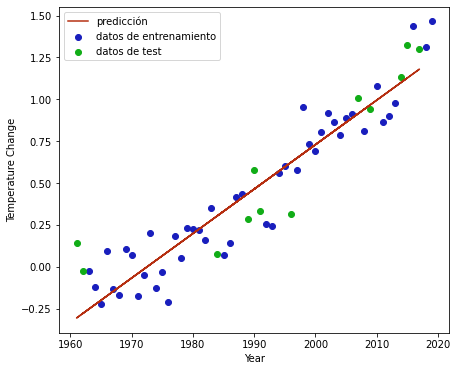

In [106]:
plt.figure(figsize=(7, 6))
ax = plt.axes()
ax.scatter(X_train,y_train, c='#191ebd', label='datos de entrenamiento')
ax.scatter(X_test,y_test, c='#11ad17', label='datos de test')
ax.plot(X_test, y_pred, c='#b52e10', label='predicción')

ax.set_xlabel('Year')
ax.set_ylabel('Temperature Change')
ax.legend()

plt.show()

Por lo pronto, no se observan indicios de Overfitting ni Underfitting; las distancias entre la recta de predicción y los puntos de dispersión de los datos de entrenamiento y prueba no presentan muchas (Underfitting) ni pocas (Overfitting) diferencias.

### Cross-Validation <a class="anchor" id="cross_val"></a>

Cross-Validation es una técnica utilizada para evaluar un modelo de Machine Learning y probar su rendimiento. Para ello vamos a utilizar la función cross_val_score, utilizando como scoring las métricas analizadas anteriormente para aplicarlas en las estimaciones.

+ Primero analizamos la precisión del modelo utilizando la función score de la biblioteca de sklearn

In [107]:
from sklearn.model_selection import cross_val_score

score = lr.score(X_train,y_train)
print("Métrica del modelo", score)

Métrica del modelo 0.8977638143470237


> Teniendo en cuenta que el mejor valor posible es "1", entonces podemos decir que tenemos una buena precisión sobre el modelo creado y entrenado.

Luego ejecutamos para cada métrica la función de cross-validation. Lo vamos a realizar puntualmente con dos divisiones (cross-validation splitting strategy).

> Cross-validation splitting strategy
El valor de este parámetro es clave para este estudio ya que indica la cantidad de divisiones o pliegues que se realizarán sobre los datos de entrenamiento, así como también la cantidad de iteraciones que se evaluará el modelo por cada pliegue.

In [108]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://scikit-learn.org/stable/_images/grid_search_cross_validation.png")

Viendo entonces, la imagen anterior, lo que se realizará es un proceso de entrenamiento y testing para cada pliegue con el fin de analizar la calidad de nuestra muestra de entrenamiento. Esto nos asegurará la generalidad de los datos de la muestra, o dicho de otra forma, que poseemos un dataset uniforme.

##### > R2

In [109]:
R2_scores = cross_val_score(lr, X_train, y_train, cv=2, scoring="r2")
 
print("Metricas cross_validation", R2_scores)
print("Precisión de %0.2f con una desviación estandar de %0.2f" % (R2_scores.mean(), R2_scores.std()))

Metricas cross_validation [0.88877266 0.90773347]
Precisión de 0.90 con una desviación estandar de 0.01


> Solo para agregar al analisis, vamos a realizar lo mismo pero con cv=5

In [110]:
#Incremento el número de folds para analizar la precisión
R2_scores = cross_val_score(lr, X_train, y_train, cv=5, scoring="r2")
 
print("Metricas cross_validation", R2_scores)
print("Precisión de %0.2f con una desviación estandar de %0.2f" % (R2_scores.mean(), R2_scores.std()))

Metricas cross_validation [0.90015719 0.88139219 0.86217804 0.82587446 0.90803708]
Precisión de 0.88 con una desviación estandar de 0.03


##### > MAE

In [111]:
MAE_scores = cross_val_score(lr, X_train, y_train, cv=2, scoring="neg_mean_absolute_error")
 
print("Métricas cross_validation", MAE_scores)
print("Media de las métricas para MAE",MAE_scores.mean())

Métricas cross_validation [-0.13549637 -0.09698359]
Media de las métricas para MAE -0.11623997724695187


##### > MSE

In [112]:
MSE_scores = cross_val_score(lr, X_train, y_train, cv=2, scoring="neg_mean_squared_error")
 
print("Métricas cross_validation", MSE_scores)
print("Media de las métricas para MSE", MSE_scores.mean())

Métricas cross_validation [-0.02578371 -0.01783757]
Media de las métricas para MSE -0.021810639090987103


##### > RMSE

In [113]:
RMSE_scores = cross_val_score(lr, X_train, y_train, cv=2, scoring="neg_root_mean_squared_error")
 
print("Métricas cross_validation", RMSE_scores)
print("Media de las métricas para RMAE", RMSE_scores.mean())

Métricas cross_validation [-0.16057305 -0.13355738]
Media de las métricas para RMAE -0.1470652146859659


#### Conclusiones sobre las metricas de cross-validation obtenidas

Si observamos cada una de las métricas obtenidas, para cada métrica de estudio, podemos decir que no encontramos diferencias significativas entre los valores. Si esto hubiera sucedido, nos podría indicar la presencia de Overfitting en algún pliegue

## Agregando CO2 como variable de nuestro modelo

Continuando con nuestro estudio, buscamos factores externos que expliquen este ascenso de temperatura. Uno de ellos es la huella de carbono, la cual representa las emisiones de gases de efecto invernadero procedentes de la actividad humana. Cada vez que viajamos en coche, cargamos el teléfono móvil o ponemos una lavadora, entre otras miles de rutinas, dejamos atrás una estela de gases que se acumulan en la atmósfera y sobrecalientan el planeta.

Para ello volvemos a recurrir a la regresion, puntualmente a la regresión lineal múltiple.

In [121]:
url = 'https://raw.githubusercontent.com/jcorvalan93/CH_DataScience/main/CO2_anual.csv'
co2 = pd.read_csv(url, sep=',', encoding='cp1252')
co2.head()

,year,Emissions in billion metric tons
0,1961,9.42
1,1962,9.75
2,1963,10.27
3,1964,10.83
4,1965,11.32


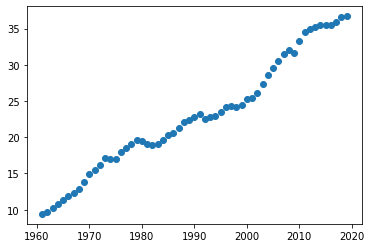

In [127]:
plt.scatter(co2.year, co2['Emissions in billion metric tons'])

In [128]:
co2[['year', 'Emissions in billion metric tons']].corr()

,year,Emissions in billion metric tons
year,1.000000,0.987105
Emissions in billion metric tons,0.987105,1.000000


In [129]:
co2[['year', 'Emissions in billion metric tons']].corr(method='spearman')

,year,Emissions in billion metric tons
year,1.000000,0.997195
Emissions in billion metric tons,0.997195,1.000000


In [126]:
time_series2 = pd.concat([time_series, co2['Emissions in billion metric tons']], axis=1)
time_series2.head()

,year,temperature_change,Emissions in billion metric tons
0,1961,0.143032,9.42
1,1962,-0.028398,9.75
2,1963,-0.026297,10.27
3,1964,-0.122865,10.83
4,1965,-0.224154,11.32


In [130]:
time_series2[['temperature_change', 'Emissions in billion metric tons']].corr()

,temperature_change,Emissions in billion metric tons
temperature_change,1.000000,0.926206
Emissions in billion metric tons,0.926206,1.000000


> Agregamos a este nuevo dataframe una columna target con una formula matematica, de modo que represente un modelo de regresión.

In [157]:
from sklearn.preprocessing import StandardScaler

time_series2.rename(columns={'temperature_change':'tmp_chg', 'Emissions in billion metric tons':'co2'}, inplace=True)
num = ['year', 'tmp_chg', 'co2']
time_series2[num] = StandardScaler().fit_transform(time_series2[num])

time_series2['target'] = 2*time_series2['tmp_chg'] + 3*time_series2['co2'] + (time_series2['year']/(2*time_series2['tmp_chg']**2 + 3*time_series2['co2']**2))
time_series2.head()

,year,tmp_chg,co2,target
0,-1.702939,-0.695447,-1.729446,-6.750551
1,-1.644217,-1.059969,-1.687310,-7.334278
2,-1.585495,-1.055503,-1.620913,-7.130567
3,-1.526773,-1.260842,-1.549410,-7.316980
4,-1.468051,-1.476220,-1.486844,-7.546545


In [158]:
time_series2[['year', 'target']].corr()

,year,target
year,1.000000,0.985783
target,0.985783,1.000000


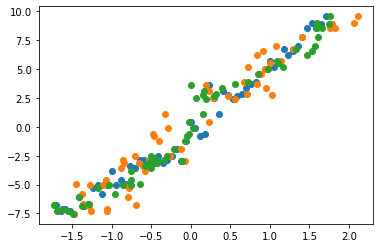

In [159]:
plt.scatter(time_series2.year, time_series2.target)
plt.scatter(time_series2.tmp_chg, time_series2.target)
plt.scatter(time_series2.co2, time_series2.target)

In [160]:
from sklearn.model_selection import train_test_split

X = time_series2.drop('target', axis=1)
y = time_series2.target

X_train, X_test, y_train, y_test = train_test_split( X, y,
                                  test_size=.2, random_state= 0)

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

ols = LinearRegression()

ols.fit(X_train, y_train)

y_pred = ols.predict(X_test)

print('r2', r2_score(y_test, y_pred))
print('mse', mean_squared_error(y_test, y_pred))
print('coef', ols.coef_)
print('intercept', ols.intercept_)

r2 0.9831464293497925
mse 0.3111053023625074
coef [2.39914445 1.83298091 0.96383414]
intercept 0.07693886707851416


Se puede observar que de las 3 variables, la de menor peso es de CO2, pero con muy poca diferncia con respecto al resto.
Por otro lado, observamos una precisión muy alta, lo cual nos podría indicar indicios de Overfitting en el modelo propuesto.
En cuanto al error, se observa un valor mucho mayor al modelo planteado anteriormente para la regresión lineal simple.

In [163]:
y_pred_train = ols.predict(X_train)

print('r2', r2_score(y_train, y_pred_train))
print('mse', mean_squared_error(y_train, y_pred_train))
#print('coef', ols.coef_)
#print('intercept', ols.intercept_)

r2 0.9867731989669964
mse 0.3693880927597263


> Utilizando los datos de entrenamiento, en lugar de los datos de test, se observan unos valores de precisión y error medio muy similares.

In [162]:
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score, mean_squared_error

lasso = Lasso(alpha=.5)

lasso.fit(X_train, y_train)

y_predl = lasso.predict(X_test)

print('r2', r2_score(y_test, y_predl))
print('mse', mean_squared_error(y_test, y_predl))
print('coef', lasso.coef_)
print('intercept', lasso.intercept_)

r2 0.9742122676053047
mse 0.4760237726713612
coef [2.23711878 1.60134401 0.86692747]
intercept 0.10966330003733005


Utilizando Lasso como modelo de regresión, y en comparación con los valores anteriores (OLS) se puede observar:


*   Una menor precisión del modelo
*   Un error medio mayor
*   Coeficientes similares pero con menor peso. CO2 continua siendo el de menor peso entre las variables.

In [164]:
y_pred_trainl = lasso.predict(X_train)

print('r2', r2_score(y_train, y_pred_trainl))
print('mse', mean_squared_error(y_train, y_pred_trainl))
#print('coef', ols.coef_)
#print('intercept', ols.intercept_)

r2 0.97799329080899
mse 0.6145867255205213


> Utilizando los datos de entrenamiento para predecir, se observa un ínfimo incremento de la precisión. Sin embargo, tenemos un aumento considerable de el error medio.

In [165]:
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score, mean_squared_error

ridge = Ridge(alpha=50)

ridge.fit(X_train, y_train)

y_predr = ridge.predict(X_test)

print('r2', r2_score(y_test, y_predr))
print('mse', mean_squared_error(y_test, y_predr))
print('coef', ridge.coef_)
print('intercept', ridge.intercept_)

r2 0.9063872228527186
mse 1.7280273684342609
coef [1.29238003 1.28257958 1.27892605]
intercept 0.15794471715441316


Utilizando Ridge como modelo de regresión, y en comparación con los valores anteriores (OLS y Lasso) se puede observar:

*   Una menor precisión del modelo
*   Un error medio mucho mayor (>x3)
*   Coeficientes muy similares. Ya no se podría tener una distinción significativa de pesos entre las variables.

In [166]:
y_pred_trainr = ridge.predict(X_train)

print('r2', r2_score(y_train, y_pred_trainr))
print('mse', mean_squared_error(y_train, y_pred_trainr))
#print('coef', ols.coef_)
#print('intercept', ols.intercept_)

r2 0.9207462176777691
mse 2.213339674722196


> Al igual que Lasso, utilizando los datos de entrenamiento para predecir, se observa un ínfimo incremento de la precisión. Sin embargo, tenemos un aumento considerable de el error medio.

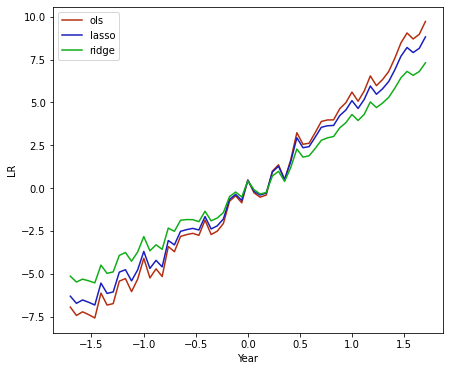

In [182]:
#['year', 'tmp_chg', 'co2']

time_series2['ols'] = ols.coef_[0]*time_series2['year'] + ols.coef_[1]*time_series2['tmp_chg'] + ols.coef_[2]*time_series2['co2'] + ols.intercept_
time_series2['lasso'] = lasso.coef_[0]*time_series2['year'] + lasso.coef_[1]*time_series2['tmp_chg'] + lasso.coef_[2]*time_series2['co2'] + lasso.intercept_
time_series2['ridge'] = ridge.coef_[0]*time_series2['year'] + ridge.coef_[1]*time_series2['tmp_chg'] + ridge.coef_[2]*time_series2['co2'] + ridge.intercept_

plt.figure(figsize=(7, 6))
ax = plt.axes()
ax.plot(time_series2['year'], time_series2['ols'], c='#b52e10', label='ols')
ax.plot(time_series2['year'], time_series2['lasso'], c='#191ebd', label='lasso')
ax.plot(time_series2['year'], time_series2['ridge'], c='#11ad17', label='ridge')

ax.set_xlabel('Year')
ax.set_ylabel('LR')
ax.legend()

plt.show()